In [1]:
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
from utils import dense, deconv2d, conv2d, nin
slim = tf.contrib.slim
ds = tf.contrib.distributions

from utils import show_digits
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


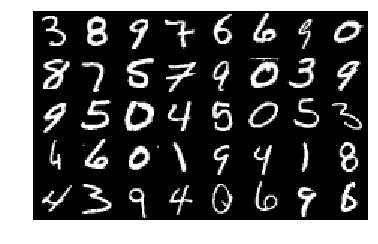

In [2]:
def sample_mnist(batch_size):
    return mnist.train.next_batch(batch_size=batch_size)[0]

show_digits(sample_mnist(40))

In [5]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=8000,
    viz_every=500,
    z_dim=256,
    x_dim=[28,28],
    optimizer='ADAM', 
    output_dim=28*28
)

In [7]:
data = tf.placeholder(tf.float32, [params['batch_size'],28,28], name='unlabeled_data_input_pl')
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

In [11]:
init_kernel = tf.random_normal_initializer(mean=0, stddev=0.05)
leakyReLu = tf.nn.leaky_relu

In [12]:
def generator(z_seed, is_training, init=False,reuse=False):
    with tf.variable_scope('generator_model', reuse=reuse):
        x = z_seed
        with tf.variable_scope('dense_1'):
            x = tf.layers.dense(x, units=4 * 4 * 512, kernel_initializer=init_kernel)
            x = tf.layers.batch_normalization(x, training=is_training, name='batchnorm_1')
            x = tf.nn.relu(x)

        x = tf.reshape(x, [-1, 4, 4, 512])

        with tf.variable_scope('deconv_1'):
            x = tf.layers.conv2d_transpose(x, 256, [5, 5], strides=[2, 2], padding='SAME', kernel_initializer=init_kernel)
            x = tf.layers.batch_normalization(x, training=is_training, name='batchnorm_2')
            x = tf.nn.relu(x)

        with tf.variable_scope('deconv_2'):
            x = tf.layers.conv2d_transpose(x, 128, [5, 5], strides=[2, 2], padding='SAME', kernel_initializer=init_kernel)
            x = tf.layers.batch_normalization(x, training=is_training, name='batchnormn_3')
            x = tf.nn.relu(x)

        with tf.variable_scope('deconv_3'):
            output = nn.deconv2d(x, num_filters=3, filter_size=[5, 5], stride=[2, 2], nonlinearity=tf.tanh, init=init,
                                 counters=counter, init_scale=0.1)
        print(output)
        return output

In [14]:
def discriminator(inp, is_training, init=False, reuse=False, getter =None):
    with tf.variable_scope('discriminator_model', reuse=reuse,custom_getter=getter):
        counter = {}
        x = tf.reshape(inp, [-1, 32, 32, 3])

        x = tf.layers.dropout(x, rate=0.2, training=is_training, name='dropout_0')

        x = nn.conv2d(x, 64, nonlinearity=leakyReLu, init=init, counters=counter)
        x = nn.conv2d(x, 64, nonlinearity=leakyReLu, init=init, counters=counter)
        x = nn.conv2d(x, 64, stride=[2, 2], nonlinearity=leakyReLu, init=init, counters=counter)

        x = tf.layers.dropout(x, rate=0.5, training=is_training, name='dropout_1')

        x = nn.conv2d(x, 128, nonlinearity=leakyReLu, init=init, counters=counter)
        x = nn.conv2d(x, 128, nonlinearity=leakyReLu, init=init, counters=counter)
        x = nn.conv2d(x, 128, stride=[2, 2], nonlinearity=leakyReLu, init=init, counters=counter)

        x = tf.layers.dropout(x, rate=0.5, training=is_training, name='dropout_2')

        x = nn.conv2d(x, 128, pad='VALID', nonlinearity=leakyReLu, init=init, counters=counter)
        x = nn.nin(x, 128, counters=counter, nonlinearity=leakyReLu, init=init)
        x = nn.nin(x, 128, counters=counter, nonlinearity=leakyReLu, init=init)
        print(x)
        x = tf.layers.max_pooling2d(x, pool_size=6, strides=1,
                                    name='avg_pool_0')
        x = tf.squeeze(x, [1, 2])

        logits = nn.dense(x, 10, nonlinearity=None, init=init, counters=counter, init_scale=0.1)
        print(logits)
        return logits

In [ ]:

# Construct generator and discriminator nets
_ = generator(noise,)
samples = generator(noise, output_dim=params['x_dim'])
real_score = discriminator(data)
fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")